### Projet de Scoring M2 TIDE

### Yasmina Haddadi - Camille Georget

Ce notebook reprend les étapes du projet, en suivant le plan suivant : 
- 1)	Présentation de la base et des variables, description des data et recodage
- 2)	Création des jeux de données
- 3)	Test des différents modèles et comparaisons 
- 4)	Conclusion (courbe de lift)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('autorisations.csv', sep=' ')  

In [3]:
df.iloc[0,:]

Carte                                0
Pays                               840
Date                        02/12/2003
Heure                         17:47:52
dateheure                   02/12/2003
CodeRep                             15
MCC                               5812
Montant                          69.25
fraude                               0
FM_Velocity_Condition_3              0
FM_Velocity_Condition_6              0
FM_Velocity_Condition_12             0
FM_Velocity_Condition_24             0
FM_Sum_3                         69.25
FM_Sum_6                         69.25
FM_Sum_12                        69.25
FM_Sum_24                        69.25
FM_Redondance_MCC_3                  1
FM_Redondance_MCC_6                  1
FM_Redondance_MCC_12                 1
FM_Redondance_MCC_24                 1
FM_Difference_Pays_3                 1
FM_Difference_Pays_6                 1
FM_Difference_Pays_12                1
FM_Difference_Pays_24                1
Name: 0, dtype: object

## Signification des variables : 
- Coderep = 00 si la transaction est accepté, sinon transaction refusée
- MCC = code commerçant
- FM_Velocity = nbre de transactions acceptées sur les X dernieres heures
- FM_Sum = montant cumulé des ...
- FM_Redondance_MCC = nb de transactions réalisées chez un meme commercant sur les X dernieres heures
- FM_Difference_Pays = nb de transactions realisées dans des pays differents sur les X dernieres heures

# I. Exploration des variables et recodage si besoin 


### Definitions de deux fonctions qui nous seront utiles (si la comprehension n'est pas facile à leur premiere lecture, avancer et y revenir quand nous les utiliserons, ça sera plus clair)
tout d'abord nous allons faire une petite fonction qui nous aidera a analyser l'impact d'une variable sur la fraude.
Cette fonction rend un dataframe, et la variable de ce dataframe qui nous interesse est la variable diff, elle indique combien de fois la modalité est plus presente dans Fraude que dans Non-Fraude, en % (je sais c'est pas tres clair). 
Par exemple, si diff = 9, alors la modalité ciblée est 9 fois plus presente parmis les fraude que parmi les non fraude.

In [4]:
# je vais faire une fonction qui affiche un dataframe avec les % des fraude et de non fraude par modalités, pour voir
# si ya des grosses difference 

# j'ai fait un code un peu compliqué pour rien, il suffit de faire la moyenne de la variable 'fraude' par modalité en fait
# mais bon ça revient au meme
def impact_fraude(var) : 
    # on calcule le % d'apparition d'une modalité dans tab0 (non fraude) et tab1 (fraude)
    tab0 = df.loc[df.fraude==0,var].value_counts()/len(df.loc[df.fraude==0,var])
    tab1 =  df.loc[df.fraude==1,var].value_counts()/len(df.loc[df.fraude==1,var])
    # on va stocker ces resultats dans des dataframe, les fusioner, puis comparer ces % et afficher les plus grosses differences
    # de % en % (pour pas etre affecter par l'echelle)
    
    d0 = pd.DataFrame(tab0)
    d1 = pd.DataFrame(tab1)
    
    d0 = d0.reset_index()
    d1 = d1.reset_index()
    
    #on merge nos tableau par index
    tablo = pd.merge(d0, d1, on = ['index'], how = 'outer')
    tablo.columns = ['index', 'a','b']
   
    #On remplace les Nan par des 0 et on va calculer lecart de % en %, par rapport a la valeur la plus grande
    tablo['missing_value'] = 1*(tablo.a.isna())+1*(tablo.b.isna())
    tablo.fillna(0,inplace=True)
    tablo['diff'] = tablo.b/tablo.a # finalement je divise par a comme ça les valeurs plus prise dans b seront plus grande
    
    #On set à 0 les diff qd ya une valeurs manquantes pour les non fraude
    tablo.loc[tablo.a.isna(),'diff']=0
    
    #on affiche le tableau
    tablo = tablo.sort_values(by=['diff'],ascending=False)
    return(tablo)

In [5]:
# On definit aussi une fonction pour afficher la table de contingence sur les données de train et de test
def results(X_train, Y_train, X_test, Y_test, model, seuil):
    # On affiche les resultats pour le train
    fiab = model.predict_proba(X_train)
    test = pd.DataFrame(fiab, columns=['non','oui'])
    test2 = 1*(test.oui>seuil)
    print(pd.crosstab(test2.values, Y_train))
     
    print("")
    print("")
    
    # On affiche les resultats pour le test
    predictions = model.predict_proba(X_test)
    test = pd.DataFrame(predictions, columns=['non','oui'])
    test2 = 1*(test.oui>seuil)
    print(pd.crosstab(test2.values, Y_test))

In [6]:
print(df.isna().sum().head(19))  # 0 NA, on va voir si y'a des valeurs aberantes 

Carte                       0
Pays                        0
Date                        0
Heure                       0
dateheure                   0
CodeRep                     0
MCC                         0
Montant                     0
fraude                      0
FM_Velocity_Condition_3     0
FM_Velocity_Condition_6     0
FM_Velocity_Condition_12    0
FM_Velocity_Condition_24    0
FM_Sum_3                    0
FM_Sum_6                    0
FM_Sum_12                   0
FM_Sum_24                   0
FM_Redondance_MCC_3         0
FM_Redondance_MCC_6         0
dtype: int64


Avant de débuter, je vais séparer un jeu de test et un jeu d'apprentissage. Ainsi je n'aurais aucune connaissance de la forme de mon jeu de test, et je ne pourrais par consequent, pas prendre de décision qui sur apprendrais sur ce jeu.

In [7]:
from sklearn.model_selection import train_test_split

#On separe notre jeu en train et test
#df, dftest = train_test_split(df, test_size=0.20, random_state=42, stratify=df.fraude)
"""
Après avoir étudié la base, je n'effectue pas de transformation qui repose sur les données de jeu de Train 
remplacement des na par la moyenne, etc...). Je vais donc, pour simplifier le code, ne pas séparer le jeu maintenant
(de cette manière je n'ai pas a effectuer les transformations deux fois). Toutes les idées de transformations ont été faites
a partir du jeu de Train, donc il n'y aura pas de rique de sur apprentissage du jeu de Test.
"""

"\nAprès avoir étudié la base, je n'effectue pas de transformation qui repose sur les données de jeu de Train \nremplacement des na par la moyenne, etc...). Je vais donc, pour simplifier le code, ne pas séparer le jeu maintenant\n(de cette manière je n'ai pas a effectuer les transformations deux fois). Toutes les idées de transformations ont été faites\na partir du jeu de Train, donc il n'y aura pas de rique de sur apprentissage du jeu de Test.\n"

## Pour chaque variable nous allons comparer la répartition des valeurs parmis les fraude et parmis les non fraudes, afin de voir si on remarque certaines tendances, ou si on peut en tirer des informations interessantes



## a) Fraude

In [8]:
df.fraude.value_counts() # très peu de fraude, données déséquilibrées, on y fera attention 

0    1144186
1       7246
Name: fraude, dtype: int64

In [9]:
1144186/(1144186+7246)

0.9937069666293797

## b) Carte

In [10]:
df.Carte.nunique() # 200k carte différentes, pour 1M lignes

198044

In [11]:
df.loc[df.fraude==1,'Carte'].nunique() # pour les fraudes, 1000 cartes différentes pour 6k fraudes

1173

On ne va pas se servir des numeros de cartes dans notre modele. On veut etre en mesure de detecter la fraude peut importe la carte utilisé

## c) Pays

In [12]:
df.Pays.nunique() # 167 pays differents ok, pas autant de données par pays c'est tres variables

167

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023AC42975F8>,
      dtype=object)

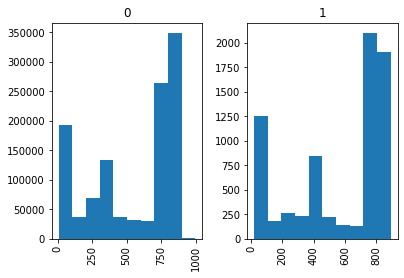

In [13]:
df['Pays'].hist(by=df['fraude'])  # a premiere vu pas de lien entre le pays et la fraude

Avec notre fonction ci dessous, on voit que certains pays sont beaucoup plus present parmis les fraude que parmis les non fraude.
On voit ici que les pays 862 et 218 ont 11 fois plus de valeurs en % dans le Fraude que dans le non Fraude. 
Ce ratio est a prendre avec des pincette car il y a tellement peu de fraudes parmis nos 1M lignes que ce ratio peu rapidement 
augmenter, mais ils peut ainsi nous aiguiller sur les pays dans lesquels il y a a priori le plus de fraude.

In [14]:
impact_fraude('Pays').head(10)

,index,a,b,missing_value,diff
102,862,0.000137,0.001656,0,12.069239
97,218,0.000151,0.001794,0,11.865760
20,792,0.005025,0.049959,0,9.942934
14,76,0.006176,0.051477,0,8.334356
80,320,0.000302,0.002070,0,6.865473
55,188,0.001004,0.005658,0,5.634588
65,608,0.000678,0.003312,0,4.883687
104,690,0.000120,0.000552,0,4.610391
13,36,0.006795,0.030500,0,4.488386
39,356,0.002201,0.009661,0,4.389758


On ne veut pas garder cette variabe avec 167 modalités, nous allons ainsi transformer la variable pays en variable 
'pays avec une forte proportion de fraude'. Nous prenons l'indice 'diff' pour nous aider a construire cette variable. On va categoriser par niveau de 'diff' avec les intervalles suivants :
- entre 0 et 0.5
- entre 0.5 et 1
- entre 1 et 2
- entre 2 et 4
- superieur a 4

Nous creeons donc la variable Pays_v2, et nous creerons de meme d'autres variables 'v2' afin de simplifier les choses.

In [15]:
tempo = impact_fraude('Pays').loc[:,['index','diff']]
tempo['Pays_v2'] = 1*(tempo['diff']>0.5)+1*(tempo['diff']>1)+1*(tempo['diff']>2)+1*(tempo['diff']>4)
tempo = tempo.loc[:,['index','Pays_v2']]
tempo.columns = ['Pays', 'Pays_v2']

In [16]:
# on merge ce tableau avec notre base 
df = pd.merge(df, tempo, on='Pays', how='outer')

In [17]:
df.Pays.value_counts().tail(30) # on voit que certains pays sont tres peu representés (moins de 20 personnes)
# mais parmis eux ya pas/peu de fraude

204    25
262    25
660    24
308    24
807    20
834    19
716    18
760    18
212    18
496    15
850    15
324    14
533    14
184    14
860    10
598     8
666     7
796     7
268     7
51      7
72      6
316     6
418     3
882     3
96      2
231     2
275     2
8       2
328     1
795     1
Name: Pays, dtype: int64

In [18]:
df.loc[df.Pays==218,'fraude'] # ok ya quand meme 186 personne dans ce pays qui a bcp de fraude 

1079674    0
1079675    0
1079676    0
1079677    0
1079678    0
          ..
1079855    0
1079856    0
1079857    0
1079858    0
1079859    0
Name: fraude, Length: 186, dtype: int64

## d) Date 
### Note : les element explicatifs de la fraude peuvent evoluer avec le temps, dans ce cas on pourrait faire un modèle par 'période', afin de mieux detecter la fraude...On va rester dans des choses simples et faire un modèle global plutôt

In [19]:
# on vérifie si cette variable est la meme que la variable dateheure
sum(df.Date == df.dateheure) #ok ce sont les memes

1151432

In [20]:
# on drop la seconde variable identique  a celle ci
df = df.drop('dateheure', axis=1)

In [21]:
type(df.Date[0])
# on va convertir en date 
df['Date'] = pd.to_datetime(df.Date) 

In [22]:
#regardons a present l'intervalle des dates, et voyons si ça a un lien avec Fraude
print(df.Date.min())
print(df.Date.max()) # on a donc des données sur 2 ans, de janv 2003 à dec 2004

2003-01-11 00:00:00
2004-12-06 00:00:00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023AC4250BE0>,
      dtype=object)

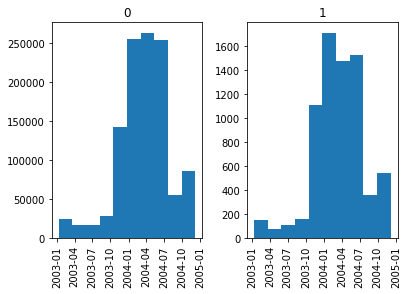

In [23]:
df['Date'].hist(by=df['fraude']) # il ne semble pas y avoir d'effet de la date sur la fraude 
# On a plus de lignes pour l'années 2004, donc plus de fraude aussi, logique 

On voit sur la table ci dessous que certains jours ont beaucoup plus de fraudes que de non fraude en proportion. Mais les 
ecart ne sont pas enorme (max= 3x plus de fraude que de non fraude en %). A voir...
On remarque que les date avec le plus gros ecarts sont soit le 21 du mois, soit le 6... coincidence ??? je ne sais pas 
Peut etre que ça correpond au jours de pays dans certains pays, ou alors ces jours ci il y avait des evenements partiuliers... On va verifier

In [24]:
impact_fraude('Date').head(8)

,index,a,b,missing_value,diff
199,2003-12-21,0.003450,0.010903,0,3.160518
208,2004-01-21,0.003404,0.009522,0,2.797306
46,2004-04-06,0.004744,0.012697,0,2.676371
114,2004-07-06,0.004191,0.010903,0,2.601578
210,2004-06-06,0.003392,0.008556,0,2.522588
147,2003-12-12,0.003850,0.008832,0,2.294206
237,2004-11-01,0.002759,0.006210,0,2.250797
47,2004-05-31,0.004739,0.010627,0,2.242485


On regarde rapidemement le nb de fraudes par pays aux 5 dates avec le plus gros ecart de fraude 

In [25]:
df.loc[(df.Date=='2003-12-21')&(df.fraude==1),'Pays'].value_counts()

826    32
76     29
380     7
724     4
528     3
756     2
840     1
56      1
Name: Pays, dtype: int64

In [26]:
df.loc[(df.Date=='2004-01-21')&(df.fraude==1),'Pays'].value_counts()

826    22
356    21
752     9
724     9
862     4
380     1
56      1
442     1
528     1
Name: Pays, dtype: int64

In [27]:
df.loc[(df.Date=='2004-04-06')&(df.fraude==1),'Pays'].value_counts()

36     47
840    14
56      9
380     6
792     5
76      3
756     2
826     2
528     2
392     2
Name: Pays, dtype: int64

In [28]:
df.loc[(df.Date=='2004-07-06')&(df.fraude==1),'Pays'].value_counts()

840    24
792    14
76     10
344     9
826     7
756     5
380     2
218     2
724     2
56      2
528     1
392     1
Name: Pays, dtype: int64

In [29]:
df.loc[(df.Date=='2004-06-06')&(df.fraude==1),'Pays'].value_counts()

840    48
344     7
76      3
792     2
756     1
724     1
Name: Pays, dtype: int64

On constate que les ecarts sont assez marqués, les premiers pays ont beaucoup plus de fraudes que ceux d'après à ces dates.
On ne pourra peut etre pas tirer grand chose de ces informations, mais cela indique que dans certains pays et acertaines dates,
il faut etre plus vigilent que d'habitude. Peut etre ces dates etaient loccasion d'evenement particulier (soldes, black friday etc...)
Ou peut etre simplement un groupe de personnes a tenter de faire plusieurs fraudes en memes temps, et elles ont étées detectées.

Voici un meme tableau pour une date prise au hasard, et on voit que les ecarts ne sont pas aussi marquées que precedemment.

In [30]:
df.loc[(df.Date=='2004-05-06')&(df.fraude==1),'Pays'].value_counts()

792    11
344    10
840    10
392     4
724     4
76      3
756     1
643     1
Name: Pays, dtype: int64

finalement je ne pense pas utiliser la date dans le modele. Le but de ce modele est de determiner les fraudes, mais aussi de trouver des facteurs explicatifs. La date, meme si elle joue un role, n'est pas un critere comme les autres, puisque ce n'est surement pas la date elleme meme qui a un effet sur la fraude, mais l'evenement qui se deroule a telle date (black friday, cyber monday ...). Je decide donc de ne pas prendre en compte la date afin de trouver un modele plus généralisable si l'on peut dire....

## e) Heure

On va convertir notre heure, et garder uniquement les minutes et les heures a priori on s'en fiche des secondes, mais je vais verifier tout de même si il y a une correlation evidente entre le nombre de seconde et la fraude ou non (par ex, des ordinateurs pourraient etre regler pour tenter une fraude a chaque minute pile, donc dans ce cas le nombre de seconde aurait de l'importance, idem pour les minutes, et pour les heures). Si on ne voit pas de correlation evidente, on pourra simplifier cette variable simplement avec heure,minutes

In [31]:
#on extrait le nombre d'heure, de minutes et de secondes
df['heure'] = [int(df.Heure[i][0:2]) for i in range(len(df.Heure))]
df['minute'] = [int(df.Heure[i][3:5]) for i in range(len(df.Heure))]
df['seconde'] = [int(df.Heure[i][6:8]) for i in range(len(df.Heure))]

On va a present regarder si des heures, minutes ou secondes reviennent plus souvent pour la fraude

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023AC1F0B358>,
      dtype=object)

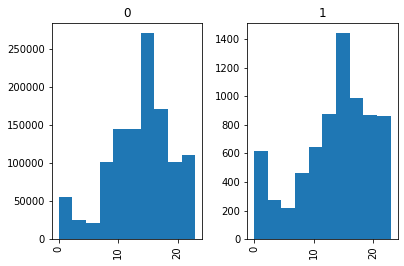

In [32]:
df['heure'].hist(by=df['fraude']) 

In [33]:
impact_fraude('heure').head(15)

,index,a,b,missing_value,diff
19,2,0.012695,0.026635,0,2.098164
20,3,0.011016,0.020701,0,1.879235
18,1,0.015298,0.027739,0,1.813247
21,4,0.010542,0.017527,0,1.662581
23,5,0.008896,0.013939,0,1.566804
22,6,0.010109,0.015733,0,1.556261
16,0,0.019950,0.030914,0,1.549589
11,20,0.038286,0.054099,0,1.413028
15,23,0.027040,0.038090,0,1.408644
9,19,0.050461,0.065553,0,1.299085


il y a plus de fraude en proportion dans la nuit (de 19h à 6h). Interessant

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023AC48906D8>,
      dtype=object)

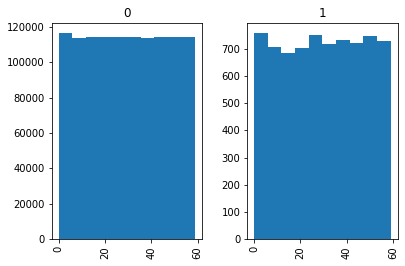

In [34]:
df['minute'].hist(by=df['fraude'])

In [35]:
impact_fraude('minute').head()# pas d'impact ici

,index,a,b,missing_value,diff
18,42,0.016715,0.020287,0,1.213708
46,20,0.016528,0.019873,0,1.202393
40,24,0.016592,0.019459,0,1.172815
33,36,0.016654,0.019183,0,1.151872
39,49,0.016594,0.019045,0,1.147681


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023AC4D8D3C8>,
      dtype=object)

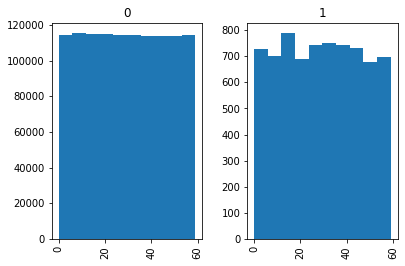

In [36]:
df['seconde'].hist(by=df['fraude'])

In [37]:
impact_fraude('seconde').head() # pas d'impact ici non plus

,index,a,b,missing_value,diff
11,15,0.016780,0.021805,0,1.299434
56,44,0.016469,0.019735,0,1.198288
29,37,0.016657,0.019873,0,1.193056
52,29,0.016506,0.019045,0,1.153818
33,0,0.016629,0.018769,0,1.128670


In [38]:
# Bilan : non, ça na pas l'air d'avoir un impact tres fort pour les minutes et les secondes,
# Jai aussi essayé de garder heure+minutes pour voir si ça avait un sens, mais finalement c'est pas super interessant, 
#on va conserver seulement les heures
df.Heure = df.heure 

In [39]:
# on drop les 3 variables creees
df = df.drop('heure', axis=1)
df= df.drop('minute', axis=1)
df = df.drop('seconde', axis=1)

Nous allons creer une v2 pour la variable heure, qui la simplifie en nuit et jour 


In [40]:
df['Heure_v2'] = 1*(df.Heure<8) + 1*(df.Heure>18) # 1 = nuit et 0 = jour 

In [41]:
# finalement, je regarde si on peut voir le taux de fraude par heure et par pays ; on repetera ce procéder plusieurs fois 
# avec des groupby pour voir si des associations de variables sont judicieuses
test = df.groupby(['Pays','Heure'])['fraude'].mean()
test.sort_values(ascending=False).head(10)
# on voit qu'il y a bcp de fraude dans certains pays a certaines heures, mais bon pas sur de pouvoir en tirer qqchose 
# ici, a revoir

Pays  Heure
214   10       1.000000
630   12       1.000000
862   7        1.000000
690   14       0.500000
188   8        0.400000
      7        0.363636
608   18       0.333333
218   0        0.285714
682   22       0.285714
218   5        0.250000
Name: fraude, dtype: float64

# f) Coderep (00 si transactions acceptée, refusée sinon)

In [42]:
df.CodeRep.value_counts() # les modalités doivent correspondre aux differents motifs de refus de transactions

0     1080453
2       38784
57      14260
7        9437
5        2182
56       2152
94       1750
54       1313
41        289
96        223
98        221
43        199
30         85
15         83
14          1
Name: CodeRep, dtype: int64

In [43]:
print(sum((df.fraude==1) & (df.CodeRep>0))/sum((df.fraude==1))) # 21% des fraudes sont des transactions refusées  
print(sum(df.CodeRep>0)/len(df.CodeRep)) # 6% des opérations sont des transactions refusées
# on fait donc l'hypothèse que les fraudes sont plus souvent des transactions refusées que les non fraudes

0.213359094672923
0.06164410924830993


In [44]:
impact_fraude('CodeRep')

,index,a,b,missing_value,diff
11,43,9.788618e-05,0.012007,0,122.659031
10,41,1.538211e-04,0.015595,0,101.382752
3,7,7.983842e-03,0.041678,0,5.220315
1,2,3.307067e-02,0.130417,0,3.943578
12,30,7.254065e-05,0.000276,0,3.804961
6,94,1.493638e-03,0.005658,0,3.788263
5,5,1.879065e-03,0.004416,0,2.350227
8,96,1.931504e-04,0.000276,0,1.429012
0,0,9.393167e-01,0.786641,0,0.837461
9,98,1.922764e-04,0.000138,0,0.717754


On remarque que les modalités 41 et 43 de CodeRep sont souvent des fraudes (40% du temps a peu pres). Il y a plus de 100 fois plus de 43 et 41 parmis les Fraude que parmis les non Fraudes en %. C'est un peu moins evident pour les autres modalités de refus de transaction. On va aussi en faire une V2 pour diminuer les modalités. On passer de 15 à 5 classes par niveau de 'diff'.
Comme il y a peu de modalité, je le fait manuellement

In [45]:
df['CodeRep_v2'] = 1*(df.CodeRep.isin([0,54,57,98]))+2*(df.CodeRep.isin([96,5]))+3*(df.CodeRep.isin([94,30,2,7]))+4*(df.CodeRep.isin([41,43]))

# g) MCC (code commerçant)

In [46]:
df.MCC.nunique() # 661 valeurs différentes de code commerçant

661

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023AC4AA07B8>,
      dtype=object)

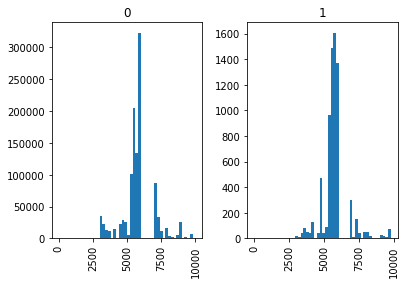

In [47]:
df['MCC'].hist(by=df['fraude'], bins=50)

In [48]:
impact_fraude('MCC').head(10)

,index,a,b,missing_value,diff
660,8044,0.000000,0.000138,1,inf
494,3748,0.000006,0.003036,0,496.275620
587,5893,0.000002,0.000276,0,157.905879
553,5718,0.000003,0.000414,0,157.905879
362,3541,0.000031,0.002760,0,90.231931
469,5198,0.000009,0.000552,0,63.162352
544,3185,0.000003,0.000138,0,39.476470
268,3771,0.000090,0.002484,0,27.595202
245,9222,0.000109,0.002208,0,20.211953
308,8042,0.000053,0.000828,0,15.531726


c'est assez impressionnant, on voit que beaucoup de modalités se retrouvent beaucoup plus souvent chez les fraude que chez les non fraude ! Il y a meme une modalité que l'on ne retrouve que chez la fraude, la n°8044 (c'est une ligne unique). 
Les MCC 3748, 5893 et 5718 ont plus de 50% de fraude (il faudra peut etre les predire tous en fraude). Et les modalités suivantes sont aussi souvent en fraude. cette variable va nous etre tres utile.
On va la simplifier en v2 par niveau de 'diff', avec moins de modalités. On passe de 660 à 9 modalités

In [49]:
tempo2 = impact_fraude('MCC').loc[:,['index','diff']]
tempo2['MCC_v2'] = 1*(tempo2['diff']>0)+1*(tempo2['diff']>1)+1*(tempo2['diff']>2)+1*(tempo2['diff']>4)+1*(tempo2['diff']>8)+1*(tempo2['diff']>16)+1*(tempo2['diff']>32)+1*(tempo2['diff']>64)
tempo2 = tempo2.loc[:,['index','MCC_v2']]
tempo2.columns = ['MCC', 'MCC_v2']

In [50]:
# on merge ce tableau avec notre base 
df = pd.merge(df, tempo2, on='MCC', how='outer')

# h) Montant

In [51]:
df.Montant.nunique()

81202

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023AC4AA0E48>,
      dtype=object)

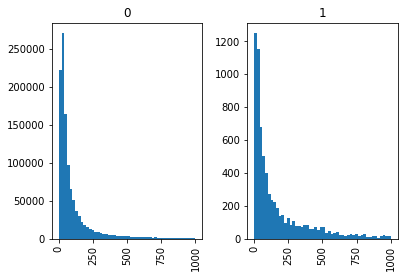

In [52]:
df.loc[df.Montant<1000,'Montant'].hist(by=df['fraude'], bins=50)

Les distributions semblent etre assez similaire pour les montant <1000, 
Ci dessous la distribution pour les valeurs de plus de 1000 et moins de 10k :
On y voit tjrs la meme distribution a peu pres.. on verra si cette variable est interessante plus tard

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023ACBA91128>,
      dtype=object)

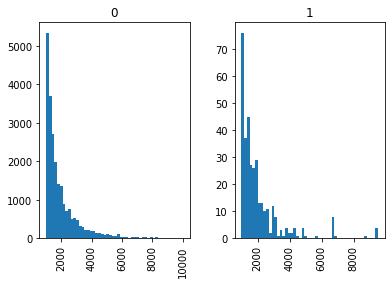

In [53]:
df.loc[(df.Montant>=1000)&(df.Montant<10000),'Montant'].hist(by=df['fraude'], bins=50)

In [54]:
df.loc[(df.Montant>=10000)&(df.fraude==1),'Montant']

504677    15000.0
Name: Montant, dtype: float64

Pour les montants au dessus de 10k ya une seule valeur qui est en fraude, elle est à 15000

# i) Nb de transactions acceptée sur les X dernieres heures

In [55]:
df.FM_Velocity_Condition_3.nunique()

47

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023ACB73D550>,
      dtype=object)

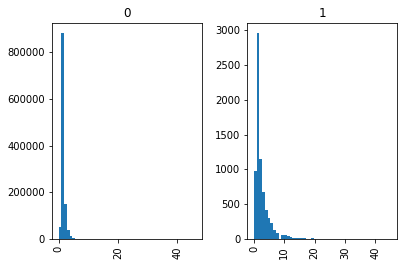

In [56]:
df['FM_Velocity_Condition_3'].hist(by=df['fraude'], bins=50)

On voit assez facilement que sur le graph des fraudes, il y a plus de valeurs avec plus de transactions

In [57]:
impact_fraude('FM_Velocity_Condition_3').head(10)

,index,a,b,missing_value,diff
23,20,0.000006,0.001104,0,180.463862
19,19,0.000010,0.001656,0,157.905879
22,21,0.000006,0.000828,0,135.347896
17,17,0.000017,0.001656,0,99.730029
15,15,0.000031,0.003036,0,99.255124
14,14,0.000038,0.003312,0,88.133514
29,24,0.000005,0.000414,0,78.952940
45,39,0.000002,0.000138,0,78.952940
39,34,0.000003,0.000276,0,78.952940
16,16,0.000024,0.001656,0,70.180391


En effet, il faudra faire attention aux lignes avec un grand nombre de transactions. Cela devrait etre identique pour 6, 12 et 24h. On va tout de meme verifier

,index,a,b,missing_value,diff
81,53,0.000000,0.000138,1,inf
43,35,0.000002,0.000414,0,236.858819
26,26,0.000009,0.001794,0,205.277643
42,34,0.000003,0.000414,0,157.905879
45,36,0.000002,0.000276,0,157.905879


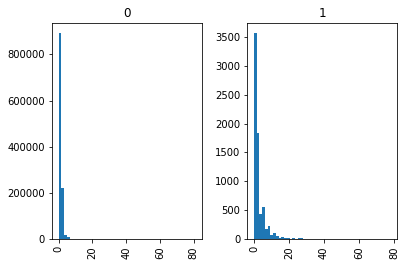

In [58]:
df['FM_Velocity_Condition_6'].hist(by=df['fraude'], bins=50)
impact_fraude('FM_Velocity_Condition_6').head() # meme constat que pour 6 heures

,index,a,b,missing_value,diff
1,2,1.688344e-01,0.164781,0,0.975989
0,1,6.967871e-01,0.327767,0,0.470398
53,52,1.747968e-06,0.000000,1,0.000000
96,67,8.739838e-07,0.000000,1,0.000000
84,83,8.739838e-07,0.000000,1,0.000000
85,81,8.739838e-07,0.000000,1,0.000000
86,56,8.739838e-07,0.000000,1,0.000000
87,57,8.739838e-07,0.000000,1,0.000000
88,58,8.739838e-07,0.000000,1,0.000000
89,59,8.739838e-07,0.000000,1,0.000000


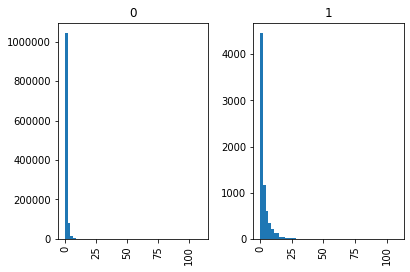

In [59]:
df['FM_Velocity_Condition_12'].hist(by=df['fraude'], bins=50)
impact_fraude('FM_Velocity_Condition_12').tail(60) # meme constat pour 12h

,index,a,b,missing_value,diff
129,73,0.000000e+00,0.000138,1,inf
125,108,0.000000e+00,0.000138,1,inf
126,123,0.000000e+00,0.000138,1,inf
127,78,0.000000e+00,0.000138,1,inf
128,118,0.000000e+00,0.000138,1,inf
92,127,8.739838e-07,0.000138,0,157.905879
59,53,1.747968e-06,0.000138,0,78.952940
49,42,9.613822e-06,0.000552,0,57.420320
32,26,4.020325e-05,0.001932,0,48.058311
41,34,2.184959e-05,0.000966,0,44.213646


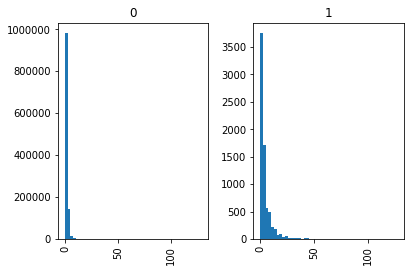

In [60]:
df['FM_Velocity_Condition_24'].hist(by=df['fraude'], bins=50)
impact_fraude('FM_Velocity_Condition_24').head(20) # meme constat pour 12h

Laquelle de ces variables garder ? Le premier arbre de decisiion effectué plus loin montrait que la variable sur 24h était la plus importante, on va voir au niveau des correlations ce que ça donne

In [61]:
df.loc[:,['FM_Velocity_Condition_3','FM_Velocity_Condition_6','FM_Velocity_Condition_12','FM_Velocity_Condition_24']].corr()

,FM_Velocity_Condition_3,FM_Velocity_Condition_6,FM_Velocity_Condition_12,FM_Velocity_Condition_24
FM_Velocity_Condition_3,1.000000,0.916418,0.819513,0.666534
FM_Velocity_Condition_6,0.916418,1.000000,0.933532,0.775551
FM_Velocity_Condition_12,0.819513,0.933532,1.000000,0.885662
FM_Velocity_Condition_24,0.666534,0.775551,0.885662,1.000000


In [62]:
# on regarde les effectifs par modalités pour savoir comment classé
df['FM_Velocity_Condition_24'].value_counts().head(15)

1     709817
2     223327
3      87994
0      51790
4      38282
5      17294
6       8351
7       4375
8       2498
9       1517
10      1029
11       756
12       575
13       459
14       338
Name: FM_Velocity_Condition_24, dtype: int64

je pensais faire une v2, mais finalement on peut garder la variable telle quelle je pense 

# j) Somme des montants cumulés sur les X dernieres heures

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023AC25329E8>,
      dtype=object)

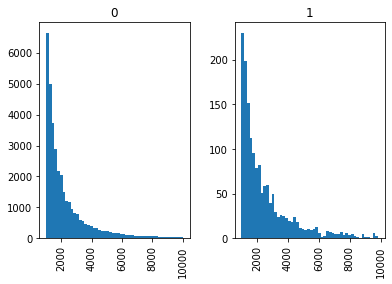

In [63]:
df.loc[(df.FM_Sum_3>1000)&(df.FM_Sum_3<10000), 'FM_Sum_3'].hist(by=df['fraude'], bins=50)

Les distributions sont similaires pour les montant <1000, entre 1k et 10k, et pour les montants > 10k, ce sont des valeurs rares dans la graph des Fraude (a droite ci dessous, donc elles sont dures a detecter comme ça je pense

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023A801742E8>,
      dtype=object)

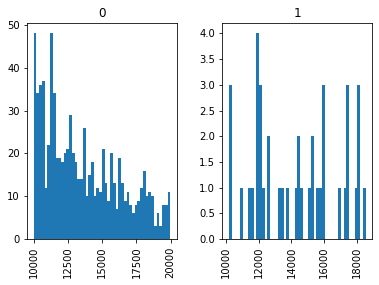

In [64]:
df.loc[(df.FM_Sum_3>10000)&(df.FM_Sum_3<20000), 'FM_Sum_3'].hist(by=df['fraude'], bins=50)

On va regarder le graph des 6, 12 et 24 dernieres heures 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023A8032C2E8>,
      dtype=object)

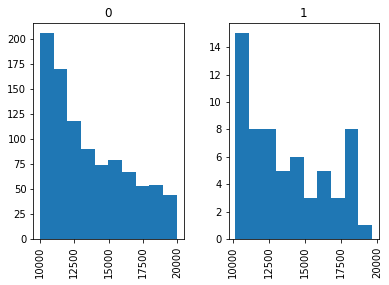

In [65]:
df.loc[(df.FM_Sum_6>10000)&(df.FM_Sum_6<20000), 'FM_Sum_6'].hist(by=df['fraude'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023A803F6DA0>,
      dtype=object)

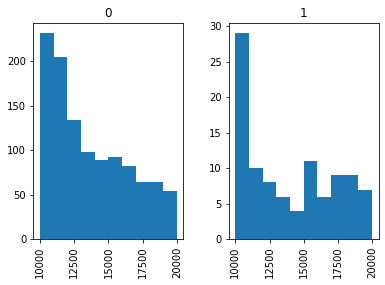

In [66]:
df.loc[(df.FM_Sum_12>10000)&(df.FM_Sum_12<20000), 'FM_Sum_12'].hist(by=df['fraude'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023A804F43C8>,
      dtype=object)

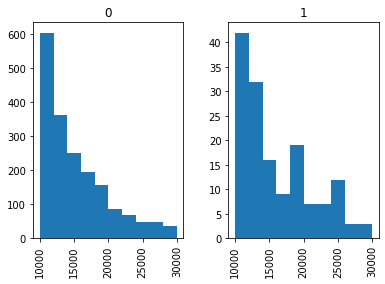

In [67]:
df.loc[(df.FM_Sum_24>10000)&(df.FM_Sum_24<30000), 'FM_Sum_24'].hist(by=df['fraude'])

les graphs se ressemblent tous, mis a part quelques saut dans les histogrammes de gauches car les valeurs sont rares...
On voit neanmoins dans le graphique ci dessous qu'il y a plus de grande valeurs en proportion chez les fraudes 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023AD1B5D5F8>,
      dtype=object)

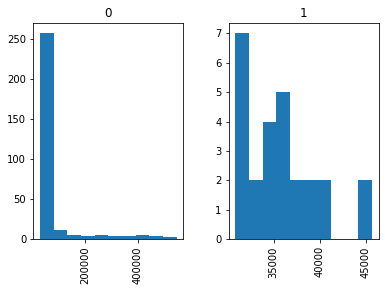

In [68]:
df.loc[df.FM_Sum_24>30000, 'FM_Sum_24'].hist(by=df['fraude'])

In [69]:
df.loc[:,['FM_Sum_3','FM_Sum_6','FM_Sum_12','FM_Sum_24']].corr() # tres correlé, on va surement en garder qu'une, celle sur 
# 24h

,FM_Sum_3,FM_Sum_6,FM_Sum_12,FM_Sum_24
FM_Sum_3,1.000000,0.986165,0.965925,0.730005
FM_Sum_6,0.986165,1.000000,0.984524,0.765130
FM_Sum_12,0.965925,0.984524,1.000000,0.797025
FM_Sum_24,0.730005,0.765130,0.797025,1.000000


# k) nb de transactions realisées chez un mm commerçant sur les X dernieres heures

In [70]:
df.FM_Redondance_MCC_3.nunique() # 39 modalités differentes pour 3h

39

,index,a,b,missing_value,diff
16,17,0.000029,0.000552,0,19.140107
8,9,0.000224,0.003588,0,16.037316
7,8,0.000329,0.005244,0,15.916242
15,16,0.000035,0.000552,0,15.790588
13,14,0.000044,0.000690,0,15.790588


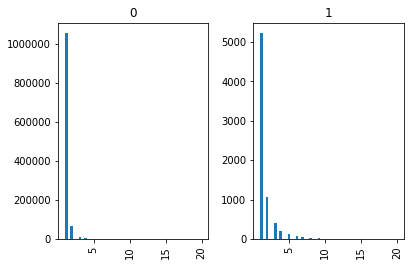

In [71]:
# ya aucune valeur >20 pour les fraudes, on affiche les histogrammes pour les données de 0 à 20
df.loc[df.FM_Redondance_MCC_3<=20,'FM_Redondance_MCC_3'].hist(by=df['fraude'], bins=50)

impact_fraude('FM_Redondance_MCC_3').head()

on voit que la les transactions ayant été effectué plus de 1 fois sont plus frequente chez les Fraude que les Non Fraudes.
Verifions les graphiques pour les 6, 12 et 24 dernieres heures.

,index,a,b,missing_value,diff
24,25,0.000010,0.000276,0,28.710160
29,30,0.000005,0.000138,0,26.317647
18,19,0.000017,0.000414,0,23.685882
21,24,0.000013,0.000276,0,21.054117
16,17,0.000033,0.000690,0,20.777089


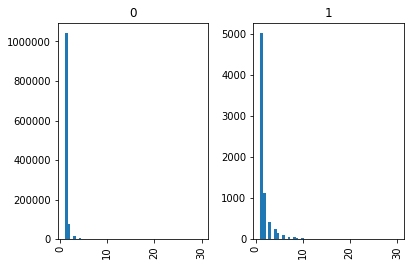

In [72]:
df.loc[df.FM_Redondance_MCC_6<=30,'FM_Redondance_MCC_6'].hist(by=df['fraude'], bins=50)
impact_fraude('FM_Redondance_MCC_6').head()
# meme conclusions pour 6 heures

,index,a,b,missing_value,diff
43,43,8.739838e-07,0.000138,0,157.905879
19,17,5.069106e-05,0.001104,0,21.780121
29,30,7.865854e-06,0.000138,0,17.545098
10,10,2.656911e-04,0.004416,0,16.621671
9,9,3.443496e-04,0.005658,0,16.431830


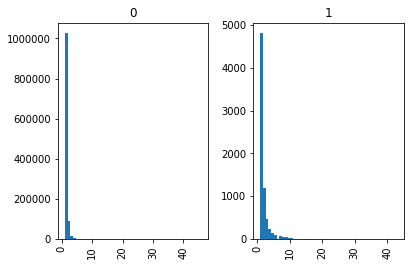

In [73]:
df['FM_Redondance_MCC_12'].hist(by=df['fraude'], bins=50)
impact_fraude('FM_Redondance_MCC_12').head()
# meme conclusions pour 12 heures

,index,a,b,missing_value,diff
22,19,4.806911e-05,0.000966,0,20.097112
23,20,4.195122e-05,0.000690,0,16.448529
18,17,8.477643e-05,0.001242,0,14.651061
20,18,6.642277e-05,0.000966,0,14.543963
15,14,1.477033e-04,0.001932,0,13.080960
10,11,3.172561e-04,0.004140,0,13.050073
7,8,7.638618e-04,0.009937,0,13.008265
14,13,1.756707e-04,0.002208,0,12.569622
9,10,4.230081e-04,0.005244,0,12.397569
8,9,5.680895e-04,0.006900,0,12.146606


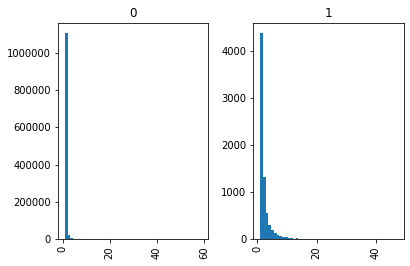

In [74]:
df['FM_Redondance_MCC_24'].hist(by=df['fraude'], bins=50)
impact_fraude('FM_Redondance_MCC_24').head(50)
# meme conclusions pour 24 heures

In [75]:
df.loc[:,['FM_Redondance_MCC_3','FM_Redondance_MCC_6','FM_Redondance_MCC_12','FM_Redondance_MCC_24']].corr()
# a voir, on va surement en garder une seule 

,FM_Redondance_MCC_3,FM_Redondance_MCC_6,FM_Redondance_MCC_12,FM_Redondance_MCC_24
FM_Redondance_MCC_3,1.000000,0.938014,0.815473,0.642582
FM_Redondance_MCC_6,0.938014,1.000000,0.928384,0.784288
FM_Redondance_MCC_12,0.815473,0.928384,1.000000,0.918083
FM_Redondance_MCC_24,0.642582,0.784288,0.918083,1.000000


In [76]:
df['FM_Redondance_MCC_24'].value_counts().head(10)

1     992586
2     115218
3      23820
4       7801
5       3581
6       2018
7       1340
8        946
9        700
10       522
Name: FM_Redondance_MCC_24, dtype: int64

Bilan : on garde cette variable telle quelle

# l) Nb de transactions realisées dans des pays differents les X dernieres heures

In [77]:
df.FM_Difference_Pays_24.nunique() # 17 modalités differentes au maximum sur les 24 dernieres heures

17

,index,a,b,missing_value,diff
3,4,0.000745,0.005106,0,6.857415
2,3,0.003451,0.017113,0,4.958301
1,2,0.043780,0.102677,0,2.345324
4,5,0.000251,0.000552,0,2.200779
0,1,0.951473,0.874551,0,0.919155
5,6,0.000145,0.000000,1,0.000000
6,7,0.000064,0.000000,1,0.000000
7,8,0.000050,0.000000,1,0.000000
8,9,0.000031,0.000000,1,0.000000
9,10,0.000011,0.000000,1,0.000000


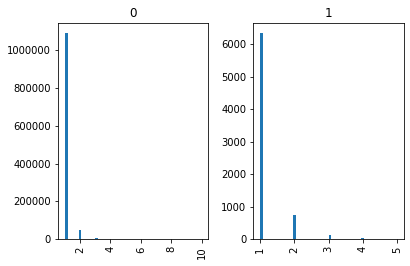

In [78]:
df['FM_Difference_Pays_3'].hist(by=df['fraude'], bins=50)
impact_fraude('FM_Difference_Pays_3').head(18)

,index,a,b,missing_value,diff
3,4,9.360366e-04,0.007728,0,8.256517
4,5,4.116464e-04,0.002346,0,5.699363
2,3,4.559573e-03,0.022219,0,4.873078
1,2,5.326057e-02,0.118548,0,2.225815
0,1,9.401767e-01,0.849020,0,0.903043
5,6,2.656911e-04,0.000138,0,0.519427
6,7,1.214837e-04,0.000000,1,0.000000
7,8,1.031301e-04,0.000000,1,0.000000
8,9,7.428862e-05,0.000000,1,0.000000
9,10,4.020325e-05,0.000000,1,0.000000


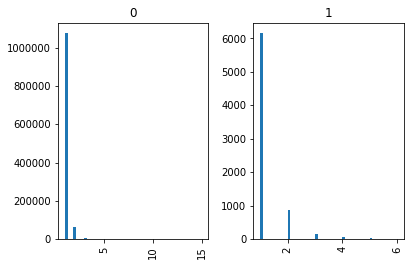

In [79]:
df['FM_Difference_Pays_6'].hist(by=df['fraude'], bins=50)
impact_fraude('FM_Difference_Pays_6').head(20)

,index,a,b,missing_value,diff
3,4,0.001062,0.009246,0,8.707567
2,3,0.005808,0.025393,0,4.372413
4,5,0.000553,0.001794,0,3.242933
5,6,0.000397,0.001242,0,3.130293
1,2,0.062875,0.139525,0,2.219080
0,1,0.928592,0.822799,0,0.886071
6,7,0.000243,0.000000,1,0.000000
7,8,0.000156,0.000000,1,0.000000
8,9,0.000116,0.000000,1,0.000000
9,10,0.000080,0.000000,1,0.000000


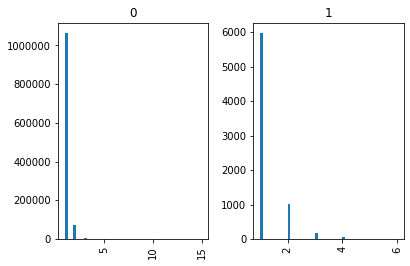

In [80]:
df['FM_Difference_Pays_12'].hist(by=df['fraude'], bins=50)
impact_fraude('FM_Difference_Pays_12').head(20)

,index,a,b,missing_value,diff
4,5,0.000589,0.006624,0,11.245523
3,4,0.001393,0.010627,0,7.627825
5,6,0.000473,0.003174,0,6.713189
2,3,0.009463,0.032846,0,3.471100
6,7,0.000456,0.000966,0,2.117512
1,2,0.083990,0.165195,0,1.966840
0,1,0.902367,0.780569,0,0.865023
12,13,0.000090,0.000000,1,0.000000
15,16,0.000011,0.000000,1,0.000000
14,15,0.000026,0.000000,1,0.000000


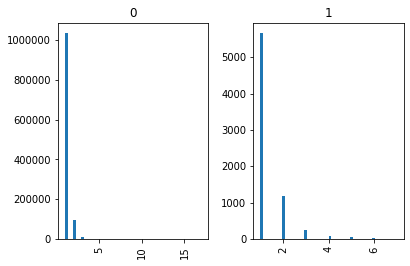

In [81]:
df['FM_Difference_Pays_24'].hist(by=df['fraude'], bins=50)
impact_fraude('FM_Difference_Pays_24').head(18)

In [82]:
df['FM_Difference_Pays_24'].value_counts()

1     1038132
2       97297
3       11065
4        1671
5         722
6         564
7         529
8         411
9         309
11        201
10        175
12        151
13        103
14         57
15         30
16         13
17          2
Name: FM_Difference_Pays_24, dtype: int64

Bilan de cette variable, dès qu'on depasse les 1 il faut se mefier de la transaction a mon avis. Pas tout a fait finalement. Entre 2 et 6-7 ya plus de fraude, mais apres yen a pas, donc la relation n'est pas forcement lineaire.

In [83]:
df.loc[:,['FM_Difference_Pays_3','FM_Difference_Pays_6','FM_Difference_Pays_12','FM_Difference_Pays_24']].corr()
# tres correlées on va en garder une je pense, on verra 

,FM_Difference_Pays_3,FM_Difference_Pays_6,FM_Difference_Pays_12,FM_Difference_Pays_24
FM_Difference_Pays_3,1.000000,0.903196,0.817996,0.700447
FM_Difference_Pays_6,0.903196,1.000000,0.922671,0.796280
FM_Difference_Pays_12,0.817996,0.922671,1.000000,0.875230
FM_Difference_Pays_24,0.700447,0.796280,0.875230,1.000000


on va laisser cette variable telle quelle 

Fin de la premiere visualisation des variable

# II. Creation du jeu de train et du jeu de test


On va creer un jeu de Train, Test, on va en mettre autant en proportion dans le jeu de train et de test.

Pour les arbres :forets il faudra aussi convertir en dummy les variables categorielles non ordonnées

In [84]:
#On va enlever les variables Carte, Date , et les variables pour lesquelles on a cree une v2

# Note IMPORTANTE : je retire les variable sur 3,6,12 heures car apres les avoir inclues dans un arbre, j'ai regardé les 'important features' et c'etait
# les variables sur 24h qui etaient le plus important (cf plus bas)
df2= df.drop(['Date','Carte','Pays','Heure','CodeRep','MCC'],axis=1)

In [85]:
df2.head() 

,Montant,fraude,FM_Velocity_Condition_3,FM_Velocity_Condition_6,FM_Velocity_Condition_12,FM_Velocity_Condition_24,FM_Sum_3,FM_Sum_6,FM_Sum_12,FM_Sum_24,...,FM_Redondance_MCC_12,FM_Redondance_MCC_24,FM_Difference_Pays_3,FM_Difference_Pays_6,FM_Difference_Pays_12,FM_Difference_Pays_24,Pays_v2,Heure_v2,CodeRep_v2,MCC_v2
0,69.25,0,0,0,0,0,69.25,69.25,69.25,69.25,...,1,1,1,1,1,1,1,0,0,1
1,10.46,0,1,1,1,3,10.46,10.46,10.46,285.51,...,1,1,1,1,1,1,1,1,1,1
2,131.49,0,1,2,2,3,131.49,66.99,66.99,198.48,...,1,1,1,1,1,1,1,1,1,1
3,53.62,0,2,2,2,2,76.55,76.55,76.55,76.55,...,1,1,1,1,1,1,1,1,1,1
4,13.49,0,1,1,1,2,13.49,13.49,13.49,18.65,...,1,2,1,1,1,1,1,1,1,1


In [86]:
from sklearn.model_selection import train_test_split

# 1ere etape, on cree 2 tableau, un de test et un de train que l'on stratifie selon 'fraude'
dftrain, dftest = train_test_split(df2, test_size=0.15, random_state=42, stratify=df2.fraude)

In [87]:
dftrain.fraude.value_counts()

0    972558
1      6159
Name: fraude, dtype: int64

In [88]:
# pour faciliter l'entrainement de mes modeles, je vais supprimer les 3/4 des valeurs 'non fraude' du jeux de train. 
# Les données sont très désequilibrés donc pour reequilibrer un peu et gagner du temps, je vais supprimer 800K obs sur les 900k
tab1 = dftrain.loc[dftrain.fraude==1,:]
tab2 = dftrain.loc[dftrain.fraude==0,:]

# on va melanger le tableau des non fraude et garder uniquement 100k ; test avec 100k pour aller plus vite dans nos algo
tab2 = tab2.sample(frac=1).reset_index(drop=True) # frac=1 c'est l'axe
tab2 = tab2.loc[:100000,:] 

#on joint les deux tab
dftrain = pd.concat([tab1,tab2])


# on va aussi essayer de construire un df equilibré (50/50)
tab2eq = tab2.loc[:6159,:] 
dftraineq = pd.concat([tab1,tab2eq])


### on peut verifier les matrices de corr de notre jeu de train et de test pour voir si elles sont bien similaires. ça nous permet de nous assurer que nos jeu de test et de train sont 'similaires'

Matrice correlation : train


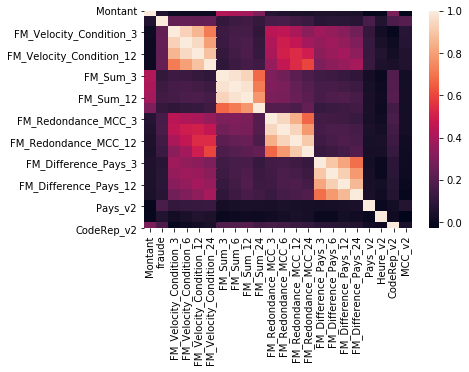

In [89]:
import seaborn as sn
corrMatrix_train = dftrain.corr()
print("Matrice correlation : train")
sn.heatmap(corrMatrix_train) 

Matrice correlation : test


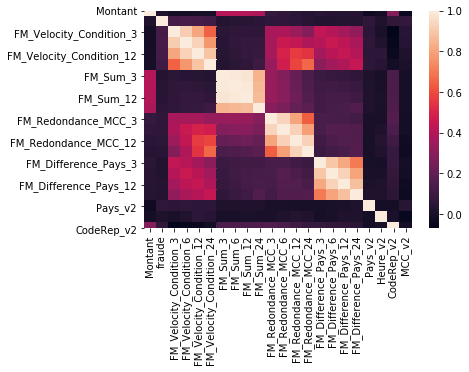

In [90]:
corrMatrix_test = dftest.corr()
print("Matrice correlation : test")
sn.heatmap(corrMatrix_test)  

### Retour au traitement des jeu de données

In [91]:
# finalement, je vais mettre quelques variables en dummy
dftrain2 = pd.get_dummies(dftrain, columns=['Pays_v2','MCC_v2','CodeRep_v2']) 
dftest2 = pd.get_dummies(dftest, columns=['Pays_v2','MCC_v2','CodeRep_v2']) 

# meme chose pour le tableau equilibré
dftraineq = pd.get_dummies(dftraineq, columns=['Pays_v2','MCC_v2','CodeRep_v2']) 

In [92]:
print(dftrain2.loc[1,:])
print('_'*100)
print(dftest2.loc[1,:]) 
# ATTENTION A bien verifier qu'on a 5 modalité de pays, 9 modalités de MCC et 5 modalités de CodeRep,
# Car il se pourrait que une modalité sautent si il n'est pas présente dans le jeu de train, et ce serait grave 
# car si elle est presente dans le jeu de test, le modèle de saurait pas quoi faire 

Montant                     151.70
fraude                        0.00
FM_Velocity_Condition_3       1.00
FM_Velocity_Condition_6       1.00
FM_Velocity_Condition_12      1.00
FM_Velocity_Condition_24      2.00
FM_Sum_3                    151.70
FM_Sum_6                    151.70
FM_Sum_12                   151.70
FM_Sum_24                   114.36
FM_Redondance_MCC_3           1.00
FM_Redondance_MCC_6           1.00
FM_Redondance_MCC_12          1.00
FM_Redondance_MCC_24          1.00
FM_Difference_Pays_3          1.00
FM_Difference_Pays_6          1.00
FM_Difference_Pays_12         1.00
FM_Difference_Pays_24         1.00
Heure_v2                      0.00
Pays_v2_0                     0.00
Pays_v2_1                     0.00
Pays_v2_2                     1.00
Pays_v2_3                     0.00
Pays_v2_4                     0.00
MCC_v2_0                      0.00
MCC_v2_1                      0.00
MCC_v2_2                      1.00
MCC_v2_3                      0.00
MCC_v2_4            

In [93]:
# je reviens a la separation classique
y_train = dftrain2.fraude
y_test = dftest2.fraude
# on fait un jeu avec les 3 variables v1 et un autre avec les 3 variable v2 (elles sont simplifiées en categorie)
x_train_v1 = dftrain2.drop(['fraude', 'FM_Velocity_Condition_3','FM_Velocity_Condition_6','FM_Velocity_Condition_12','FM_Sum_3','FM_Sum_6','FM_Sum_12','FM_Redondance_MCC_3','FM_Redondance_MCC_6','FM_Redondance_MCC_12', 'FM_Difference_Pays_3','FM_Difference_Pays_6','FM_Difference_Pays_12'], axis=1)
x_test_v1 = dftest2.drop(['fraude', 'FM_Velocity_Condition_3','FM_Velocity_Condition_6','FM_Velocity_Condition_12','FM_Sum_3','FM_Sum_6','FM_Sum_12','FM_Redondance_MCC_3','FM_Redondance_MCC_6','FM_Redondance_MCC_12', 'FM_Difference_Pays_3','FM_Difference_Pays_6','FM_Difference_Pays_12'], axis=1)

# meme chose pour le jeu equilibré, on choisis de garder les variables v1 pour lui
y_traineq = dftraineq.fraude
x_traineq = dftraineq.drop(['fraude','FM_Velocity_Condition_3','FM_Velocity_Condition_6','FM_Velocity_Condition_12','FM_Sum_3','FM_Sum_6','FM_Sum_12','FM_Redondance_MCC_3','FM_Redondance_MCC_6','FM_Redondance_MCC_12', 'FM_Difference_Pays_3','FM_Difference_Pays_6','FM_Difference_Pays_12'], axis=1)


# On fait un dernier jeu equilibré avec les variables sur 3-6-12-24h pour pouvoir faire la PCA
x_traineq_pca = dftraineq.drop(['fraude'], axis=1)
x_test_pca = dftest2.drop(['fraude'], axis = 1) 

In [94]:
# a present on peut faire la pca pour le dernier jeux equilbré afin de voir si ça apportera qqchose 


# je vais ajouter 8 variables qui seront les coordonnées des 2 axes pricipaux
# des la pca pour les 4 variables sur 3-6-12-24h ; et apres on supprimera ces variables. On le fait pr le train et le test
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=2))])

FM_Velocity_pca = pipeline.fit_transform(x_traineq_pca.loc[:,['FM_Velocity_Condition_3','FM_Velocity_Condition_6','FM_Velocity_Condition_12','FM_Velocity_Condition_24']])
FM_Velocity_pca2 = pipeline.transform(x_test_pca.loc[:,['FM_Velocity_Condition_3','FM_Velocity_Condition_6','FM_Velocity_Condition_12','FM_Velocity_Condition_24']])

FM_Sum_pca = pipeline.fit_transform(x_traineq_pca.loc[:,['FM_Sum_3','FM_Sum_6','FM_Sum_12','FM_Sum_24']])
FM_Sum_pca2 = pipeline.transform(x_test_pca.loc[:,['FM_Sum_3','FM_Sum_6','FM_Sum_12','FM_Sum_24']])


FM_Redondance_pca = pipeline.fit_transform(x_traineq_pca.loc[:,['FM_Redondance_MCC_3','FM_Redondance_MCC_6','FM_Redondance_MCC_12','FM_Redondance_MCC_24']])
FM_Redondance_pca2 = pipeline.transform(x_test_pca.loc[:,['FM_Redondance_MCC_3','FM_Redondance_MCC_6','FM_Redondance_MCC_12','FM_Redondance_MCC_24']])

FM_Difference_pca = pipeline.fit_transform(x_traineq_pca.loc[:,['FM_Difference_Pays_3','FM_Difference_Pays_6','FM_Difference_Pays_12','FM_Difference_Pays_24']])
FM_Difference_pca2 = pipeline.transform(x_test_pca.loc[:,['FM_Difference_Pays_3','FM_Difference_Pays_6','FM_Difference_Pays_12','FM_Difference_Pays_24']])

# on peut maitenant ajouter ces coordonnées aux tableau prncipal, on fera different jeux par la suite
x_traineq_pca['FM_Velocity_pca1'] =  FM_Velocity_pca[:,0]
x_traineq_pca['FM_Velocity_pca2'] =  FM_Velocity_pca[:,1]
x_test_pca['FM_Velocity_pca1'] =  FM_Velocity_pca2[:,0]
x_test_pca['FM_Velocity_pca2'] =  FM_Velocity_pca2[:,1]

x_traineq_pca['FM_SUM_pca1'] = FM_Sum_pca[:,0]
x_traineq_pca['FM_SUM_pca2'] = FM_Sum_pca[:,1]
x_test_pca['FM_SUM_pca1'] = FM_Sum_pca2[:,0]
x_test_pca['FM_SUM_pca2'] = FM_Sum_pca2[:,1]

x_traineq_pca['FM_Redondance_pca1'] = FM_Redondance_pca[:,0]
x_traineq_pca['FM_Redondance_pca2'] = FM_Redondance_pca[:,1]
x_test_pca['FM_Redondance_pca1'] = FM_Redondance_pca2[:,0]
x_test_pca['FM_Redondance_pca2'] = FM_Redondance_pca2[:,1]

x_traineq_pca['FM_Difference_pca1'] = FM_Difference_pca[:,0]
x_traineq_pca['FM_Difference_pca2'] = FM_Difference_pca[:,1] 
x_test_pca['FM_Difference_pca1'] = FM_Difference_pca2[:,0]
x_test_pca['FM_Difference_pca2'] = FM_Difference_pca2[:,1] 


# Ok finalement on peut supprimer les variables qui ont servis a la pca, et on aura fini le traitement de ce tableau 
x_traineq_pca = x_traineq_pca.drop(['FM_Velocity_Condition_3','FM_Velocity_Condition_6','FM_Velocity_Condition_12', 'FM_Velocity_Condition_24','FM_Sum_3','FM_Sum_6','FM_Sum_12','FM_Sum_24','FM_Redondance_MCC_3','FM_Redondance_MCC_6','FM_Redondance_MCC_12','FM_Redondance_MCC_24', 'FM_Difference_Pays_3','FM_Difference_Pays_6','FM_Difference_Pays_12', 'FM_Difference_Pays_24'], axis=1)
x_test_pca = x_test_pca.drop(['FM_Velocity_Condition_3','FM_Velocity_Condition_6','FM_Velocity_Condition_12', 'FM_Velocity_Condition_24','FM_Sum_3','FM_Sum_6','FM_Sum_12','FM_Sum_24','FM_Redondance_MCC_3','FM_Redondance_MCC_6','FM_Redondance_MCC_12','FM_Redondance_MCC_24', 'FM_Difference_Pays_3','FM_Difference_Pays_6','FM_Difference_Pays_12', 'FM_Difference_Pays_24'], axis=1)

On obtient donc 4 jeux de données diff a tester : 
    - un avec les variable 24h inchangés, en quanti
    - un avec les v2 des variables 24h
    - un jeu equilibré avec les variables 24h en quanti
    - un jeu equilibré avec les variables sur 3-6-12-24h resumé par 2 dim d'une pca 

In [95]:
# essayons de faire un jeu plus equilibré avec smote (a partir du train_v1) # APrès des test ce n'est pas convaincant, 
# on abandonne le SMOTE

from imblearn.over_sampling import SMOTE
# transform the dataset
oversample = SMOTE(sampling_strategy=0.2)
x_smote, y_smote = oversample.fit_resample(x_train_v1, y_train)

Using TensorFlow backend.


TypeError: expected bytes, Descriptor found

## Regardons rapidement quels sont les important features ds un arbre afin de selectionner les variables sur 3-6-12-24h (fait auparavant, j'ai enlevé les variables sur 3-6-12h car les 24h etaient les plus importantes sur 1 arbre



In [ ]:
from sklearn.tree import DecisionTreeClassifier

# il met quelques minutes a tourner 
arbre = DecisionTreeClassifier(max_depth=10)
arbre.fit(x_train_v1 , y_train)

results(x_train_v1, y_train, x_test_v1, y_test,arbre, 0.03)

# Voici le tableau des feature les plus importants
l1 = []
l2 = []
for name, score in zip(list(x_train_v1.columns) , arbre.feature_importances_):
    l1.append(name)
    l2.append(score)
l1l2 = {'name':  l1,
        'score': l2}

importance = pd.DataFrame (l1l2, columns = ['name','score'])
# on trie les feature par importance
importance.sort_values(by=['score'], ascending=False, inplace=True)
importance.head(20)

# Dimensionality Reduction and Clustering: a partir du jeu equilibré

In [ ]:
# On centre reduit les données de x_traineq avant d'appliquer ces methode
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
scaler = StandardScaler()
redu = scaler.fit_transform(x_traineq)

# T-SNE Implementation
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(redu)


# PCA Implementation
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(redu)


# TruncatedSVD
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(redu)

In [ ]:
import matplotlib.patches as mpatches
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_traineq == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_traineq == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y_traineq == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y_traineq == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y_traineq == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y_traineq == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

In [ ]:
# Les données sont pas super séparables en dim 2 ; peut être est ce a cause des modifications effectuées sur les variables, 
# peut etre que ce n'est juste pas visible en 2 dimensions. Nous continuons tout de même notre quête ultime 

# III. Construction et comparaison des modèles

## Arbre boostée

### xgboost

# 1) RANDOM SEARCH SUR XGBOOST AVEC GPU



In [95]:
# on definit une fonction pour timé
from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


In [96]:
from xgboost import XGBClassifier
mon_xgb = XGBClassifier(n_estimators=1000, objective='binary:logistic') # faire plus destimateur si possible (1000 au moins )
                   # tree_method='gpu_hist', verbosity=1) # eval_set=(x_test_v1,y_test), eval_metric='auc' # j'ai retiré ce parametre
# explication des parametres : 
# eval metric = Evaluation metrics for validation data, a default metric will be assigned according to objective 
# (rmse for regression, and error for classification, mean average precision for ranking)

# silent = Whether to print messages while running boosting. (deprecated, use verbosity instead)

# auc = air sous la courbe (precision rappel) --> pas forcement le meilleur indicateur dans notre cas car on veut minimisr les faux negatif 

On va voir quel type de score on va utiliser pour selectionner le meilleur set d'hyperparametre  :

premiers bilan sur peu d'iterations sur randomized search cv : le scoring importe pas bcp car a la fin on peut ajuster un peu comme on veut le seuil 

score testé : 

- f1_weighted

- recall 

- ma propre loss (construite ci dessous)

In [97]:
# on va essayer de definir notre propre loss
from sklearn.metrics import fbeta_score, make_scorer, confusion_matrix
import numpy as np
def my_custom_loss_func(y_true, y_pred, poids=20):
  FP = confusion_matrix(y_true, y_pred)[0,1]
  FN = confusion_matrix(y_true, y_pred)[1,0]
  return (poids*FN+FP) # les FN comptent n fois plus que les FP


mon_score = make_scorer(my_custom_loss_func, greater_is_better=False)

voici quelques hyperparametre a tuner (a retrouver sur https://www.datacamp.com/community/tutorials/xgboost-in-python#hyperparameters)
- learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
- max_depth: determines how deeply each tree is allowed to grow during any boosting round.
- subsample: percentage of samples used per tree. Low value can lead to underfitting.
- colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
- n_estimators: number of trees you want to build.
- objective: determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability.


XGBoost also supports regularization parameters to penalize models as they become more complex and reduce them to simple (parsimonious) models.

- gamma: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
- alpha: L1 regularization on leaf weights. A large value leads to more regularization.
- lambda: L2 regularization on leaf weights and is smoother than L1 regularization.

In [154]:
# essayons un randomized search cv avec le gpu, et avec un score qui n'est pas l'accuracy mais plutot 
# quelquechose qui favoriserait la detection de fraude 
%%time 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
params = {
        'scale_pos_weight':[25,50,100], # poids des 1 p/r aux 0
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.5, 0.67, 0.85, 1.0],
        'colsample_bytree': [0.5, 0.67, 0.85, 1.0],
        'max_depth': [3, 5, 7, 10, 15, 20],
        'learning_rate': [0.005, 0.01, 0.02, 0.05]
        

        }

cross_val = StratifiedKFold(n_splits=2)
random_search = RandomizedSearchCV(mon_xgb, param_distributions=params, n_iter=1, scoring=mon_score, n_jobs=-1, cv=cross_val, verbose=10, random_state=1001 )
# scoring va nous permettre de definir le critere a optimiser, et je suppose que le 'best model' sera selectionné en fct de ce score, cest ça

""" Note : loss != scoring 
Loss: The metric that your fitting method optimizes for a given model with all hyperparameters set.
Scoring: The metric used to choose between your optimized model (i.e. how you pick the best hyperparameters).
"""



# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(x_train_v1, y_train)
timer(start_time) 



Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   39.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   39.3s finished



 Time taken: 0 hours 0 minutes and 59.89 seconds.
CPU times: user 13.3 s, sys: 7.51 s, total: 20.8 s
Wall time: 60 s


In [155]:
best_params = random_search.best_params_
best_params

{'colsample_bytree': 1.0,
 'gamma': 1.5,
 'learning_rate': 0.02,
 'max_depth': 7,
 'min_child_weight': 5,
 'scale_pos_weight': 100,
 'subsample': 0.67}

Pour x_train_v1, avec 
{'colsample_bytree': 0.67,
 'gamma': 1.5,
 'learning_rate': 0.005,
 'max_depth': 7,
 'min_child_weight': 1,
 'scale_pos_weight': 25,
 'subsample': 0.5}           
 On arrive a 5% d'erreur pour 65% de bonne prediction chez les fraudes. On constate le meme genre de resultats avec des petites variabtions de param, et aussi avec le x_train_v2 
 


In [156]:
results(x_train_v1, y_train, x_test_v1, y_test, random_search.best_estimator_, 0.7)

fraude      0     1
row_0              
0       75387   445
1       24614  5714


fraude       0    1
row_0              
0       127463  217
1        44165  870


In [157]:
sum(y_train)

6159

Essayons mtn d'entrainer notre modele avec les parametre trouvés, avec un lr plus faible et plus d'arbre


In [98]:
from xgboost import XGBClassifier

finalxgb = XGBClassifier(n_estimators=1000,
                        colsample_bytree=0.67,
                        gamma=1.5, 
                        learning_rate = 0.01, 
                        max_depth= 7, 
                        min_child_weight= 1, 
                        scale_pos_weight = 25, 
                        subsample =0.5,
                        #tree_method='gpu_hist',
                        verbosity=1)
finalxgb.fit(x_train_v1, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.67, gamma=1.5,
              learning_rate=0.01, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=25, seed=None,
              silent=None, subsample=0.5, verbosity=1)

In [99]:
results(x_train_v1, y_train, x_test_v1, y_test, finalxgb, 0.75) # pas mal, 95% acc avec 65% des fraude bien predit 

fraude      0     1
row_0              
0       95310  2227
1        4691  3932


fraude       0    1
row_0              
0       163074  416
1         8554  671


In [102]:
# essayons de nouveau d'entrainer un xgboost mais avec le jeu equilibré cette fois

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.5, 0.67, 0.85, 1.0],
        'colsample_bytree': [0.5, 0.67, 0.85, 1.0],
        'max_depth': [3, 5, 7, 10, 15, 20],
        'learning_rate': [0.005, 0.01, 0.02, 0.05]
        

        }

cross_val = StratifiedKFold(n_splits=2)
random_search = RandomizedSearchCV(mon_xgb, param_distributions=params, n_iter=50, n_jobs=-1, cv=cross_val, verbose=10) # a ajouter : scoring=mon_score
# scoring va nous permettre de definir le critere a optimiser, et je suppose que le 'best model' sera selectionné en fct de ce score, cest ça

""" Note : loss != scoring 
Loss: The metric that your fitting method optimizes for a given model with all hyperparameters set.
Scoring: The metric used to choose between your optimized model (i.e. how you pick the best hyperparameters).
"""



# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(x_traineq, y_traineq)
timer(start_time) 


Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  6.5min remaining:   16.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.7min finished



 Time taken: 0 hours 6 minutes and 53.72 seconds.


In [103]:
results(x_traineq, y_traineq, x_test_v1, y_test, random_search.best_estimator_, 0.7) #c'est pas mal du tout sur le jeu de test
# par rapport a ce quon a deja eu, c'est meme quasi mieux , et memepas besoin de mon score il sert a rien, jsuis deg 

fraude     0     1
row_0             
0       5879  2540
1        281  3619


fraude       0    1
row_0              
0       162011  412
1         9617  675


In [105]:
best_params = random_search.best_params_
print(best_params)
"""'subsample': 0.85,
 'min_child_weight': 1,
 'max_depth': 5,
 'learning_rate': 0.005,
 'gamma': 1.5,
 'colsample_bytree': 1.0
 """

{'subsample': 0.85, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.005, 'gamma': 1.5, 'colsample_bytree': 1.0}


"'subsample': 0.85,\n 'min_child_weight': 1,\n 'max_depth': 5,\n 'learning_rate': 0.005,\n 'gamma': 1.5,\n 'colsample_bytree': 1.0\n "

In [191]:
# dernier essaie avec le jeux equilibré pca

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.5, 0.67, 0.85, 1.0],
        'colsample_bytree': [0.5, 0.67, 0.85, 1.0],
        'max_depth': [3, 5, 7, 10, 15, 20],
        'learning_rate': [0.005, 0.01, 0.02, 0.05]
        

        }

cross_val = StratifiedKFold(n_splits=2)
random_search = RandomizedSearchCV(mon_xgb, param_distributions=params, n_iter=20, n_jobs=-1, cv=cross_val, verbose=10) # a ajouter : scoring=mon_score
# scoring va nous permettre de definir le critere a optimiser, et je suppose que le 'best model' sera selectionné en fct de ce score, cest ça

""" Note : loss != scoring 
Loss: The metric that your fitting method optimizes for a given model with all hyperparameters set.
Scoring: The metric used to choose between your optimized model (i.e. how you pick the best hyperparameters).
"""



# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(x_traineq_pca, y_traineq)
timer(start_time) 


Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:  2.0min remaining:   40.8s
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:  2.4min remaining:   20.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.6min finished



 Time taken: 0 hours 2 minutes and 46.01 seconds.


In [193]:
results(x_traineq_pca, y_traineq, x_test_pca, y_test, random_search.best_estimator_, 0.75) # ça change pas grand chose ...

fraude     0     1
row_0             
0       5998  2597
1        162  3562


fraude       0    1
row_0              
0       163468  457
1         8160  630


## Continuons avec les arbres, essyons une foret et comparons notre modele xgb avec cette foret a l'aide des courbes ROC AUC

In [107]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
weights={0:1, 1:25}
params2 = {
        'criterion':['gini','entropy'], 
        'bootstrap': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'max_features':list(range(2, 32)),
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600, 800, 1000]  #, 1200, 1400, 1600, 1800, 2000]
        }

cross_val = StratifiedKFold(n_splits=2)


In [161]:
rnd_search_cv = RandomizedSearchCV(RandomForestClassifier (class_weight = weights), params2,scoring=mon_score, cv=cross_val, n_iter=1, verbose=1, n_jobs=-1)
rnd_search_cv.fit(x_train_v1, y_train)

best_params = rnd_search_cv.best_params_
best_params

"""
{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 13,
 'max_depth': 10,
 'criterion': 'gini',
 'bootstrap': False} apres 20 iterations
"""

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  2.1min finished


"\n{'n_estimators': 800,\n 'min_samples_split': 5,\n 'min_samples_leaf': 4,\n 'max_features': 13,\n 'max_depth': 10,\n 'criterion': 'gini',\n 'bootstrap': False} apres 20 iterations\n"

In [176]:
results(x_train_v1, y_train, x_test_v1, y_test, rnd_search_cv.best_estimator_, 0.3) # ok

fraude      0     1
row_0              
0       96466     0
1        3535  6159


fraude       0    1
row_0              
0       162693  677
1         8935  410


In [177]:
from sklearn.ensemble import RandomForestClassifier
finalforet = RandomForestClassifier (class_weight = weights, 
                                     n_estimators = 800, 
                                     min_samples_split = 5, 
                                     min_samples_leaf = 4, 
                                     max_features = 13, 
                                     max_depth = 10, 
                                     criterion ='gini',
                                     bootstrap = False)

finalforet.fit(x_train_v1, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 25}, criterion='gini',
                       max_depth=10, max_features=13, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=800, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [180]:
results(x_train_v1, y_train, x_test_v1, y_test, finalforet, 0.75) # pas mal aussi

fraude      0     1
row_0              
0       95068  2270
1        4933  3889


fraude       0    1
row_0              
0       162621  436
1         9007  651


In [109]:
# essayons  aussi avec le jeu equilibré 
rnd_search_cv = RandomizedSearchCV(RandomForestClassifier (), params2,scoring=mon_score, cv=cross_val, n_iter=20, verbose=1, n_jobs=-1)
rnd_search_cv.fit(x_traineq, y_traineq)

best_params = rnd_search_cv.best_params_
best_params

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.5min finished


{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 18,
 'max_depth': 90,
 'criterion': 'entropy',
 'bootstrap': True}

In [112]:
results(x_traineq, y_traineq, x_test_v1, y_test, rnd_search_cv.best_estimator_, 0.8) # ok c'est pas mal encore... super

fraude     0     1
row_0             
0       6160  1457
1          0  4702


fraude       0    1
row_0              
0       160669  480
1        10959  607


# Petit Adaboost pour finir avec les methodes basées sur des arbres


In [164]:
# on regarde une premiere foret avec adaboost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

#on entraine 200 arbres a un seul noeud. C'est lestimateur de base de adaboost_classifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(class_weight = weights), n_estimators=10,
    algorithm="SAMME.R", learning_rate=0.01, random_state=42) 
#samme.r = modelisation additive par etape utilisant une fonction de cout exponentielle multi classe, le r = reel, il nous 
# permet de faire un vote souple car le modele dispose d'un predict_proba()

#je sais pas bien comment il choisit la variable du noeud, ya surement du hasard (parcelle aleatoires)
ada_clf.fit(x_train_v1, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight={0: 1,
                                                                       1: 25},
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                      

In [165]:
results(x_train_v1, y_train, x_test_v1, y_test, ada_clf, 0.5)

fraude      0     1
row_0              
0       98365    14
1        1636  6145


fraude       0    1
row_0              
0       164653  673
1         6975  414


In [166]:
parametre = {'n_estimators' : [10,25,50,100,200,500], 'learning_rate' : [0.01, 0.02, 0.05, 0.1]} 



rnd_search_cv = RandomizedSearchCV(AdaBoostClassifier(
    DecisionTreeClassifier(class_weight = weights), 
    algorithm="SAMME.R", random_state=42) , parametre, n_iter=2, verbose=1, cv=cross_val, n_jobs=-1, scoring=mon_score)


rnd_search_cv.fit(x_train_v1, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    6.9s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   59.3s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                      class_weight={0: 1,
                                                                                                    1: 25},
                                                                                      criterion='gini',
                                                                                      max_depth=None,
                                                                                      max_features=None,
                                                                                      max_leaf_nodes=None,
                                                                             

In [167]:
results(x_train_v1, y_train, x_test_v1, y_test, rnd_search_cv.best_estimator_, 0.5)

fraude      0     1
row_0              
0       98365    14
1        1636  6145


fraude       0    1
row_0              
0       166140  689
1         5488  398


In [324]:
# comparons les trois modeles obtenus (xgboost et foret et ada) avec leur courbes AUC ROC
# les trois modeles sont finalforet, finalxgb et ada_clf

from sklearn.metrics import roc_curve, auc
# Comparaison des 3 modèles
import matplotlib.pyplot as plt

#model1
fpr_train_m1, tpr_train_m1, thresholds_train_m1 = roc_curve(y_train, finalforet.predict_proba(x_train_v1)[:,1])
roc_auc_train_m1 = auc(fpr_train_m1, tpr_train_m1)

#model2
fpr_train_m2, tpr_train_m2, thresholds_train_m2 = roc_curve(y_train, finalxgb.predict_proba(x_train_v1)[:,1])
roc_auc_train_m2 = auc(fpr_train_m2, tpr_train_m2)

#model3
fpr_train_m3, tpr_train_m3, thresholds_train_m3 = roc_curve(y_train, ada_clf.predict_proba(x_train_v1)[:,1])
roc_auc_train_m3 = auc(fpr_train_m3, tpr_train_m3)



plt.figure()
lw = 2
plt.plot(fpr_train_m1, tpr_train_m1, color='darkorange',
         lw=lw, label='Train -m1 - ROC curve (area = %0.2f)' % roc_auc_train_m1)

plt.plot(fpr_train_m2, tpr_train_m2, color='darkblue',
         lw=lw, label='Train -m2) - ROC curve (area = %0.2f)' % roc_auc_train_m2)

plt.plot(fpr_train_m3, tpr_train_m3, color='darkgreen',
         lw=lw, label='Train -m3 - ROC curve (area = %0.2f)' % roc_auc_train_m3)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparaison courve ROC Train ')
plt.legend(loc="lower right")
plt.show()


#model1
fpr_test_m1, tpr_test_m1, thresholds_test_m1 = roc_curve(y_test, finalforet.predict_proba(x_test_v1)[:,1])
roc_auc_test_m1 = auc(fpr_test_m1, tpr_test_m1)

#model2
fpr_test_m2, tpr_test_m2, thresholds_test_m2 = roc_curve(y_test, finalxgb.predict_proba(x_test_v1)[:,1])
roc_auc_test_m2 = auc(fpr_test_m2, tpr_test_m2)

#model3
fpr_test_m3, tpr_test_m3, thresholds_test_m3 = roc_curve(y_test, ada_clf.predict_proba(x_test_v1)[:,1])
roc_auc_test_m3 = auc(fpr_test_m3, tpr_test_m3)


plt.figure()
lw = 2
plt.plot(fpr_test_m1, tpr_test_m1, color='darkorange',
         lw=lw, label='Test -m1 - ROC curve (area = %0.2f)' % roc_auc_test_m1)

plt.plot(fpr_test_m2, tpr_test_m2, color='darkblue',
         lw=lw, label='Test -m2) - ROC curve (area = %0.2f)' % roc_auc_test_m2)

plt.plot(fpr_test_m3, tpr_test_m3, color='darkgreen',
         lw=lw, label='Test -m3 - ROC curve (area = %0.2f)' % roc_auc_test_m3)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparaison courve ROC Test ')
plt.legend(loc="lower right")
plt.show()

# on voit bien que le adaboost surajuste, faudrait le revoir, et le xgboost est un peu mieux que la foret mais despi 

y_test_predict_proba = finalforet.predict_proba(x_test_v1)[:,1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_predict_proba)
roc_auc_test = auc(fpr_test, tpr_test)

NameError: name 'finalforet' is not defined

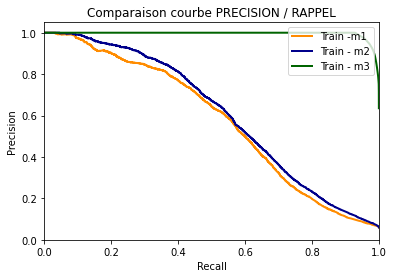

In [169]:
# passons aux courbes precision rappel
# Recherche sur le train
from sklearn.metrics import precision_recall_curve
precision_train_m1, recall_train_m1, thresholds_train_m1 = precision_recall_curve(y_train,
                                                                         finalforet.predict_proba(x_train_v1)[:,1])
precision_train_m2, recall_train_m2, thresholds_train_m2 = precision_recall_curve(y_train,
                                                                         finalxgb.predict_proba(x_train_v1)[:,1])
precision_train_m3, recall_train_m3, thresholds_train_m3 = precision_recall_curve(y_train,
                                                                         ada_clf.predict_proba(x_train_v1)[:,1])

plt.figure()
lw = 2
plt.plot(recall_train_m1,precision_train_m1, color='darkorange',
         lw=lw,  label='Train -m1')

plt.plot(recall_train_m2,precision_train_m2, color='darkblue',
         lw=lw, label='Train - m2')

plt.plot(recall_train_m3,precision_train_m3, color='darkgreen',
         lw=lw, label='Train - m3')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Comparaison courbe PRECISION / RAPPEL')
plt.legend(loc="upper right")
plt.show()

# le adaboost surajuste de fou, voir bloc suivant pour les resultat su le jeu de test, plus significatif

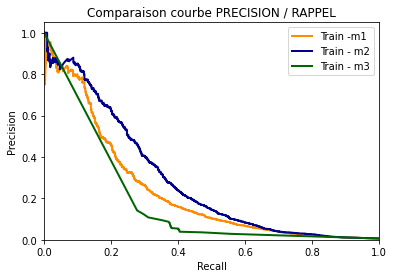

In [170]:
# passons aux courbes precision rappel
# Recherche sur le test
from sklearn.metrics import precision_recall_curve
precision_train_m1, recall_train_m1, thresholds_train_m1 = precision_recall_curve(y_test,
                                                                         finalforet.predict_proba(x_test_v1)[:,1])
precision_train_m2, recall_train_m2, thresholds_train_m2 = precision_recall_curve(y_test,
                                                                         finalxgb.predict_proba(x_test_v1)[:,1])
precision_train_m3, recall_train_m3, thresholds_train_m3 = precision_recall_curve(y_test,
                                                                         ada_clf.predict_proba(x_test_v1)[:,1])

plt.figure()
lw = 2
plt.plot(recall_train_m1,precision_train_m1, color='darkorange',
         lw=lw,  label='Train -m1')

plt.plot(recall_train_m2,precision_train_m2, color='darkblue',
         lw=lw, label='Train - m2')

plt.plot(recall_train_m3,precision_train_m3, color='darkgreen',
         lw=lw, label='Train - m3')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Comparaison courbe PRECISION / RAPPEL')
plt.legend(loc="upper right")
plt.show()

# on voit que le xgboost est mieux 

# Regression logistique
Pour utiliser la regression lineaire, je vais devoir convertir certaines variables en dummy sinon il va estimer des effets lineaires qui n'ont pas lieux d'etre. ça a ete fait, on utilise les jeu de données 'log' pour ce modele

In [325]:
#on fait aussi un jeux sans les modalités 0 des variables dummy pour la regression logistique, sinon on aurait des variables
# colineaires
x_train_log = x_train_v1.drop(['Pays_v2_0', 'MCC_v2_0','CodeRep_v2_0'], axis=1)
x_test_log = x_test_v1.drop(['Pays_v2_0', 'MCC_v2_0','CodeRep_v2_0'], axis=1)

# meme chose pour le jeu equilibré
x_traineq2 = x_traineq.drop(['Pays_v2_0', 'MCC_v2_0','CodeRep_v2_0'], axis=1)

# On va aussi normaliser ces variables, afin de pouvoir s'en servir avec d'autre modele comme les SVM par exemple
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train_log)
x_train_log = scaler.transform(x_train_log)
x_test_log = scaler.transform(x_test_log)


# idem pour le jeu equilibré, on va refit le standard scaler
scaler.fit(x_traineq2)
x_traineq2 = scaler.transform(x_traineq2)
x_test_log2 = scaler.transform(x_test_log)


In [326]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(x_train_log,y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [328]:
results(x_train_log, y_train, x_test_log, y_test, log_clf, 0.05) # c'est pas si mal, mais moins bien que xgboost

fraude      0     1
row_0              
0       69793  1574
1       30208  4585


fraude       0    1
row_0              
0       119417  258
1        52211  829


In [332]:
# meme chose avec le jeu equilibré
log_clf.fit(x_traineq2,y_traineq)
results(x_traineq2, y_traineq, x_test_log2, y_test, log_clf, 0.55) # pas mal mais pas ouf la 

fraude     0     1
row_0             
0       5394  2247
1        766  3912


fraude       0    1
row_0              
0       162524  701
1         9104  386


In [333]:
# Finalement je vais essayer de trouver le meilleur set d'hyperparametre pour une regression logistique 
# je reprend le code de Pierre Bioche
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

# on va tester avec plusieurs dictionnaire d'hyperparametres
param_dict_bayes_elasticnet = {
    'penalty': ['elasticnet'], 
    'solver': ['saga'],
    'l1_ratio' : [0.1*x for x in range(10)],
    'fit_intercept': [True, False],
    'tol': [0.1*x for x in range(10)],
    'C':[0.1*x for x in range(10)]}

param_dict_bayes_l1 = {
    'penalty': ['l1'], 
    'solver': ['liblinear','saga'],
    'fit_intercept': [True,False],
    'tol': [0.1*x for x in range(10)],
    'C':[0.1*x for x in range(10)]}

param_dict_bayes_l2 = {
    'penalty': ['l2'], 
    'solver': ['newton-cg', 'lbfgs','sag', 'saga'],
    'fit_intercept': [True,False],
    'tol': [0.1*x for x in range(10)],
    'C':[0.1*x for x in range(10)]}  



rnd_search_cv = RandomizedSearchCV(LogisticRegression(), param_dict_bayes_elasticnet,scoring='roc_auc', cv=3, n_iter=100, verbose=1, n_jobs=-1)
rnd_search_cv.fit(x_traineq2, y_traineq)

rnd_search_cv2 = RandomizedSearchCV(LogisticRegression(), param_dict_bayes_l1,scoring='roc_auc', cv=3, n_iter=100, verbose=1, n_jobs=-1)
rnd_search_cv2.fit(x_traineq2, y_traineq)

rnd_search_cv3 = RandomizedSearchCV(LogisticRegression(), param_dict_bayes_l2,scoring='roc_auc', cv=3, n_iter=100, verbose=1, n_jobs=-1)
rnd_search_cv3.fit(x_traineq2, y_traineq)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.8s finished
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.6s finished
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    4.6s finished


RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.0, 0.1, 0.2,
                                              0.30000000000000004, 0.4, 0.5,
                                              0.6000000000000001,
                                              0.7000000000000001, 0.8, 0.9],
                                        'fit_intercept': [True, False],
                                        'penalty': ['l2'],
                                        'solver': ['newton-cg', 'lbfgs', 'sag',
                                                   'saga'],
                                        'tol': [0.0, 0.1, 0.2,
                                                0.30000000000000004, 0.4, 0.5,
                                                0.6000000000000001,
                                                0.7000000000000001, 0.8, 0.9]},
                   scoring='roc_auc', verbose=1)

In [344]:
results(x_traineq2, y_traineq, x_test_log2, y_test, rnd_search_cv.best_estimator_ , 0.85)
print('-'*100)
results(x_traineq2, y_traineq, x_test_log2, y_test, rnd_search_cv2.best_estimator_ , 0.8)
print('-'*100)
results(x_traineq2, y_traineq, x_test_log2, y_test, rnd_search_cv3.best_estimator_ , 0.55) # les resultats sont moyens 

fraude     0     1
row_0             
0       6062  4045
1         98  2114


fraude       0    1
row_0              
0       162194  681
1         9434  406
----------------------------------------------------------------------------------------------------
fraude     0     1
row_0             
0       6020  3721
1        140  2438


fraude       0    1
row_0              
0       160602  654
1        11026  433
----------------------------------------------------------------------------------------------------
fraude     0     1
row_0             
0       5394  2247
1        766  3912


fraude       0    1
row_0              
0       162061  688
1         9567  399


# SVM

In [119]:
from sklearn.svm import SVC
svm_clf = SVC(gamma="auto", random_state=42)

In [200]:
svm_clf.fit(x_train_log,y_train) #prend du temps a tourner
results(x_train_log, y_train, x_test_log, y_test, log_clf, 0.1) # interessant aussi, a ajouter avec les autres modele pour voir si le stacking peut ameliorer
# qqchose 

fraude      0     1
row_0              
0       91381  2827
1        8620  3332


fraude       0    1
row_0              
0       156963  471
1        14665  616


In [120]:
# meme chose avec le jeu equilibré
svm_clf.fit(x_traineq2,y_traineq)
results(x_traineq2, y_traineq, x_test_log2, y_test, log_clf, 0.5) # pas trop mal mais pas ouf la encore 

fraude     0     1
row_0             
0       5107  1965
1       1053  4194


fraude       0    1
row_0              
0       164763  729
1         6865  358


# Reseau de neurone 


In [345]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = x_traineq2.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [346]:
undersample_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 22)                506       
_________________________________________________________________
dense_56 (Dense)             (None, 32)                736       
_________________________________________________________________
dense_57 (Dense)             (None, 2)                 66        
Total params: 1,308
Trainable params: 1,308
Non-trainable params: 0
_________________________________________________________________


In [348]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [349]:
undersample_model.fit(x_traineq2, y_traineq, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Train on 9855 samples, validate on 2464 samples
Epoch 1/20
 - 1s - loss: 0.5422 - accuracy: 0.7066 - val_loss: 0.7385 - val_accuracy: 0.6327
Epoch 2/20
 - 0s - loss: 0.4890 - accuracy: 0.7505 - val_loss: 0.6366 - val_accuracy: 0.7342
Epoch 3/20
 - 0s - loss: 0.4799 - accuracy: 0.7533 - val_loss: 0.5891 - val_accuracy: 0.7715
Epoch 4/20
 - 0s - loss: 0.4739 - accuracy: 0.7569 - val_loss: 0.6201 - val_accuracy: 0.7573
Epoch 5/20
 - 0s - loss: 0.4701 - accuracy: 0.7600 - val_loss: 0.6856 - val_accuracy: 0.6851
Epoch 6/20
 - 0s - loss: 0.4669 - accuracy: 0.7590 - val_loss: 0.6073 - val_accuracy: 0.7512
Epoch 7/20
 - 0s - loss: 0.4646 - accuracy: 0.7615 - val_loss: 0.5875 - val_accuracy: 0.7687
Epoch 8/20
 - 0s - loss: 0.4609 - accuracy: 0.7646 - val_loss: 0.6665 - val_accuracy: 0.6940
Epoch 9/20
 - 0s - loss: 0.4594 - accuracy: 0.7645 - val_loss: 0.6482 - val_accuracy: 0.7285
Epoch 10/20
 - 0s - loss: 0.4587 - accuracy: 0.7646 - val_loss: 0.5916 - val_accuracy: 0.7760
Epoch 11/20
 - 0s - l

In [350]:
undersample_predictions = undersample_model.predict(x_test_log2, batch_size=200, verbose=0)

In [351]:
undersample_fraud_predictions = undersample_model.predict_classes(x_test_log2, batch_size=200, verbose=0)

In [352]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[154477  17151]
 [   562    525]]


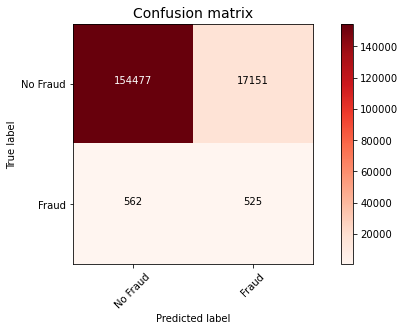

In [353]:
undersample_cm = confusion_matrix(y_test, undersample_fraud_predictions)
actual_cm = confusion_matrix(y_test, y_test)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, cmap=plt.cm.Reds)

# IV.  Courbe de llift avec le modèle xgbfinal (+ tableau des valeurs associées)

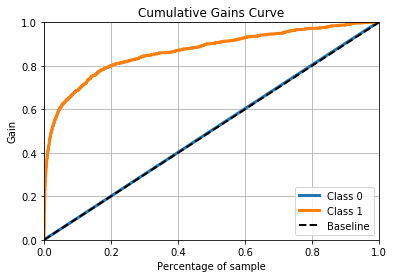

In [100]:
predicted_probas = finalxgb.predict_proba(x_test_v1)


import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)

plt.show()
# On voit qu'en ciblant prédisant en 'fraude' les 20% des transactions les plus probable, on detecte 80% des fraudes

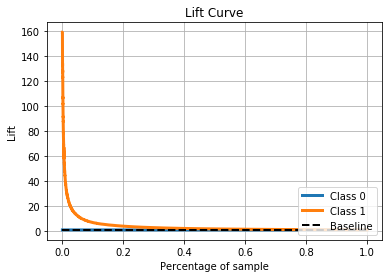

In [101]:
skplt.metrics.plot_lift_curve(y_test, predicted_probas)
plt.show()

In [142]:
# construisons la table de lift
test = pd.DataFrame(np.transpose(np.array([y_test, predicted_probas[:,1]])),
                columns=['true', 'proba'])

test.sort_values(by='proba', ascending=False, inplace=True)

In [149]:
# dans notre jeu de test, on compte 1087 'fraude', 172 715 valeurs en tout
c = []
ind = 0
for i in range (10) : 
    c.append(sum(test.true[0:ind+17271])/1087) 
    ind = ind+17271
    

In [164]:
table = pd.DataFrame(np.transpose(np.array([[x+1 for x in range(10)], c])),
                columns=['deciles utilisés', '% des fraudes prédits'])

In [165]:
table

,deciles utilisés,% des fraudes prédits
0,1.0,0.687213
1,2.0,0.801288
2,3.0,0.846366
3,4.0,0.871205
4,5.0,0.903404
5,6.0,0.930083
6,7.0,0.949402
7,8.0,0.972401
8,9.0,0.988040
9,10.0,1.000000
